# Menghitung jarak antara data lama (buka tutup) masing masing 100 data dengan data baru 1 data menggunakan Dynamic Time Warping (DTW)  

## Suara Buka  

### Import Library  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import glob
import os
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from tqdm.notebook import tqdm
import IPython.display as ipd

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 5)

print("Libraries siap digunakan.")

Libraries siap digunakan.


### Load Data "BUKA" & Visualisasi Waveform

Total file referensi 'BUKA' dimuat: 100


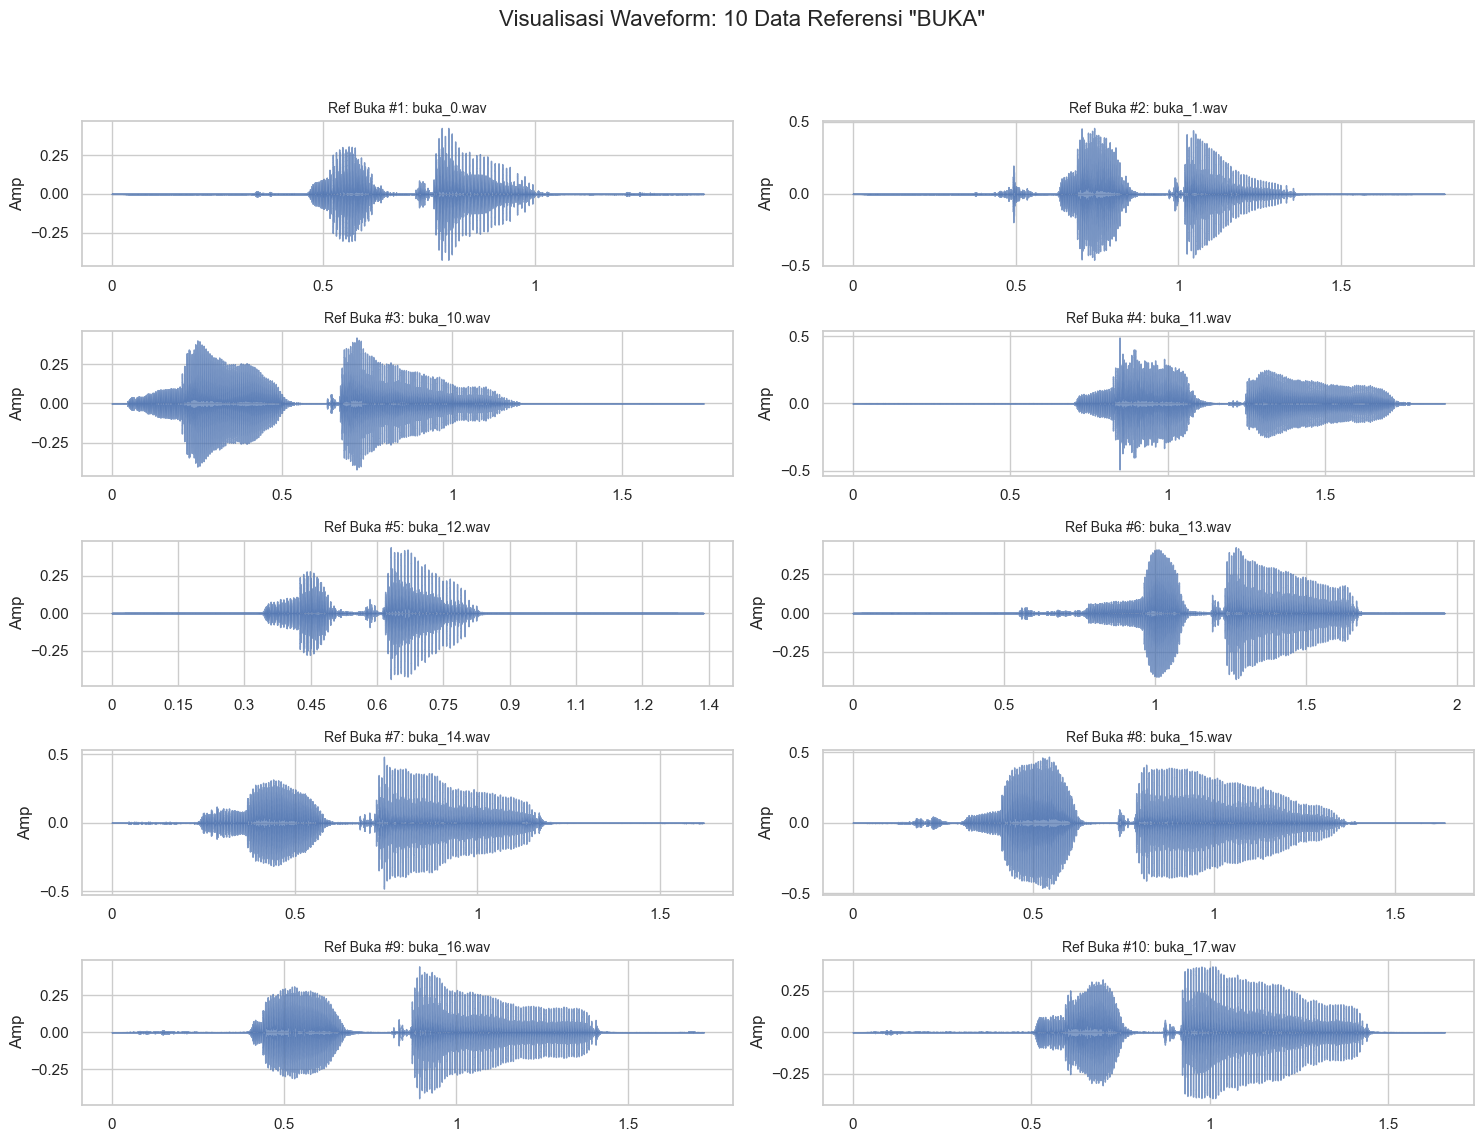

In [2]:
DATASET_PATH = "dataset/" 
TARGET_SR = 22050

# Load file BUKA
files_buka = glob.glob(os.path.join(DATASET_PATH, "**", "buka", "*.wav"), recursive=True)
print(f"Total file referensi 'BUKA' dimuat: {len(files_buka)}")

# Visualisasi Data
fig, axes = plt.subplots(5, 2, figsize=(15, 12)) 
fig.suptitle('Visualisasi Waveform: 10 Data Referensi "BUKA"', fontsize=16)
axes = axes.flatten()

for i in range(10):
    if i < len(files_buka):
        y, sr = librosa.load(files_buka[i], sr=TARGET_SR)
        librosa.display.waveshow(y, sr=sr, ax=axes[i], alpha=0.7)
        axes[i].set_title(f"Ref Buka #{i+1}: {os.path.basename(files_buka[i])}", fontsize=10)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("Amp")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Hitung Jarak (DTW) Data "BUKA"

In [3]:
FILE_BARU = os.path.join("uji", "buka", "buka_baru.wav")

# Fungsi Ekstraksi
def extract_mfcc_dtw(file_path):
    try:
        y, sr = librosa.load(file_path, sr=TARGET_SR, mono=True)
        y, _ = librosa.effects.trim(y, top_db=20)
        if len(y) < 1000: return None
        return librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T 
    except: return None

# Ekstrak Input Baru
print(f"Menganalisis Input: {FILE_BARU}")
input_seq = extract_mfcc_dtw(FILE_BARU)

results_buka = []

if input_seq is not None:
    print("Menghitung jarak terhadap 100 data 'Buka'")
    for ref_file in tqdm(files_buka):
        ref_seq = extract_mfcc_dtw(ref_file)
        if ref_seq is not None:
            dist, path = fastdtw(input_seq, ref_seq, dist=euclidean)
            results_buka.append({
                'file': os.path.basename(ref_file),
                'path_full': ref_file,
                'jarak': dist / len(path) # Normalisasi
            })
            
    df_buka = pd.DataFrame(results_buka)
    print("Perhitungan Selesai.")
else:
    print("Gagal memproses file input baru.")

Menganalisis Input: uji\buka\buka_baru.wav
Menghitung jarak terhadap 100 data 'Buka'


  0%|          | 0/100 [00:00<?, ?it/s]

Perhitungan Selesai.


### Statistik Hasil Jarak (Kelas BUKA)

STATISTIK JARAK (BUKA)
Jarak Terdekat (Min) : 57.6976
Jarak Terjauh (Max)  : 156.8671
Rata-rata Jarak      : 89.2654
Standar Deviasi      : 15.1315


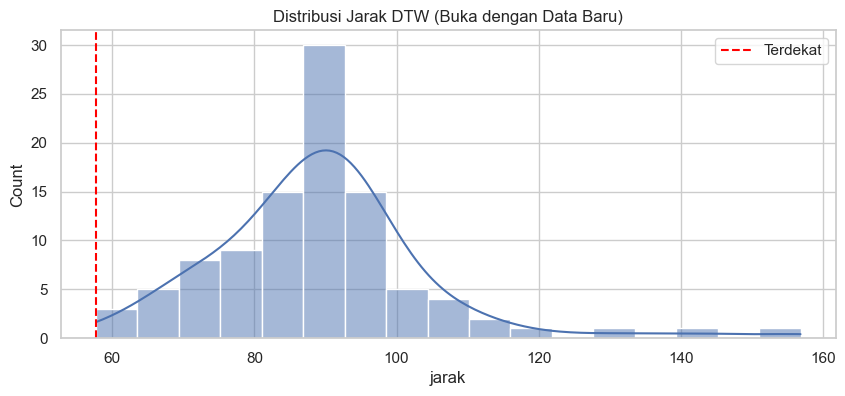

In [4]:
if not df_buka.empty:
    print("STATISTIK JARAK (BUKA)")
    stats = df_buka['jarak'].describe()
    print(f"Jarak Terdekat (Min) : {stats['min']:.4f}")
    print(f"Jarak Terjauh (Max)  : {stats['max']:.4f}")
    print(f"Rata-rata Jarak      : {stats['mean']:.4f}")
    print(f"Standar Deviasi      : {stats['std']:.4f}")
    
    # Visualisasi Histogram
    plt.figure(figsize=(10, 4))
    sns.histplot(df_buka['jarak'], kde=True)
    plt.axvline(stats['min'], color='red', linestyle='--', label='Terdekat')
    plt.title("Distribusi Jarak DTW (Buka dengan Data Baru)")
    plt.legend()
    plt.show()

### Ranking 20 Data Teratas (BUKA)

TOP 20 PERINGKAT KEMIRIPAN:


,file,jarak
1,buka_34.wav,57.697561
2,buka_40.wav,61.626497
3,buka_42.wav,62.423257
4,buka_35.wav,66.244141
5,buka_1.wav,66.451202
6,buka_28.wav,68.786437
7,buka_3.wav,69.323130
8,buka_38.wav,69.335570
9,buka_36.wav,69.593213
10,buka_10.wav,70.976407


C:\Users\acer\AppData\Local\Temp\ipykernel_30568\3644687597.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='jarak', y='file', data=top_20, palette='viridis')


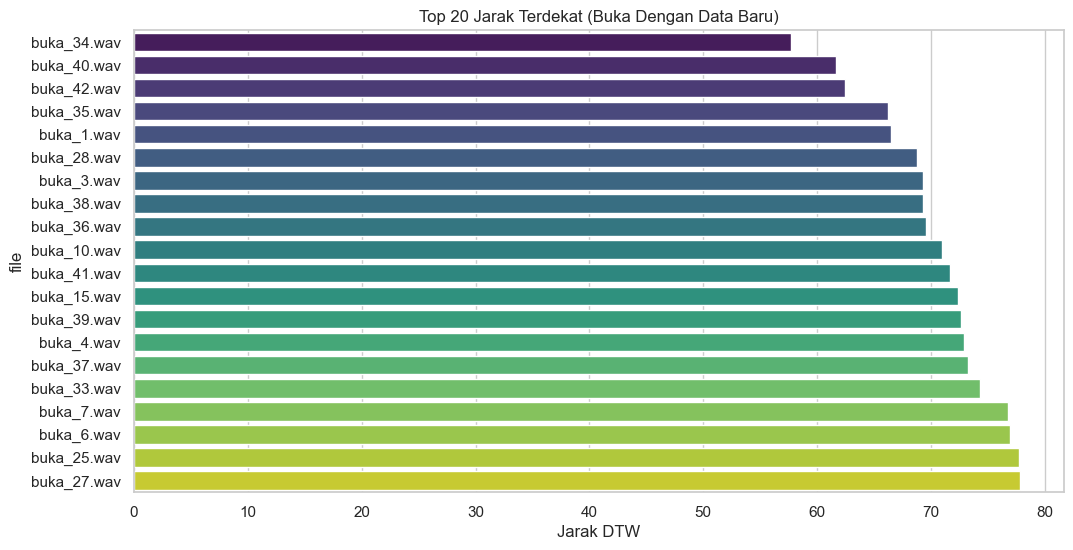

In [5]:
if not df_buka.empty:
    # Ranking
    df_buka_sorted = df_buka.sort_values(by='jarak', ascending=True).reset_index(drop=True)
    df_buka_sorted.index += 1
    
    print("TOP 20 PERINGKAT KEMIRIPAN:")
    display(df_buka_sorted[['file', 'jarak']].head(20))
    
    # Visualisasi Bar Plot
    plt.figure(figsize=(12, 6))
    top_20 = df_buka_sorted.head(20)
    sns.barplot(x='jarak', y='file', data=top_20, palette='viridis')
    plt.title("Top 20 Jarak Terdekat (Buka Dengan Data Baru)")
    plt.xlabel("Jarak DTW")
    plt.show()

### Visualisasi Perbandingan

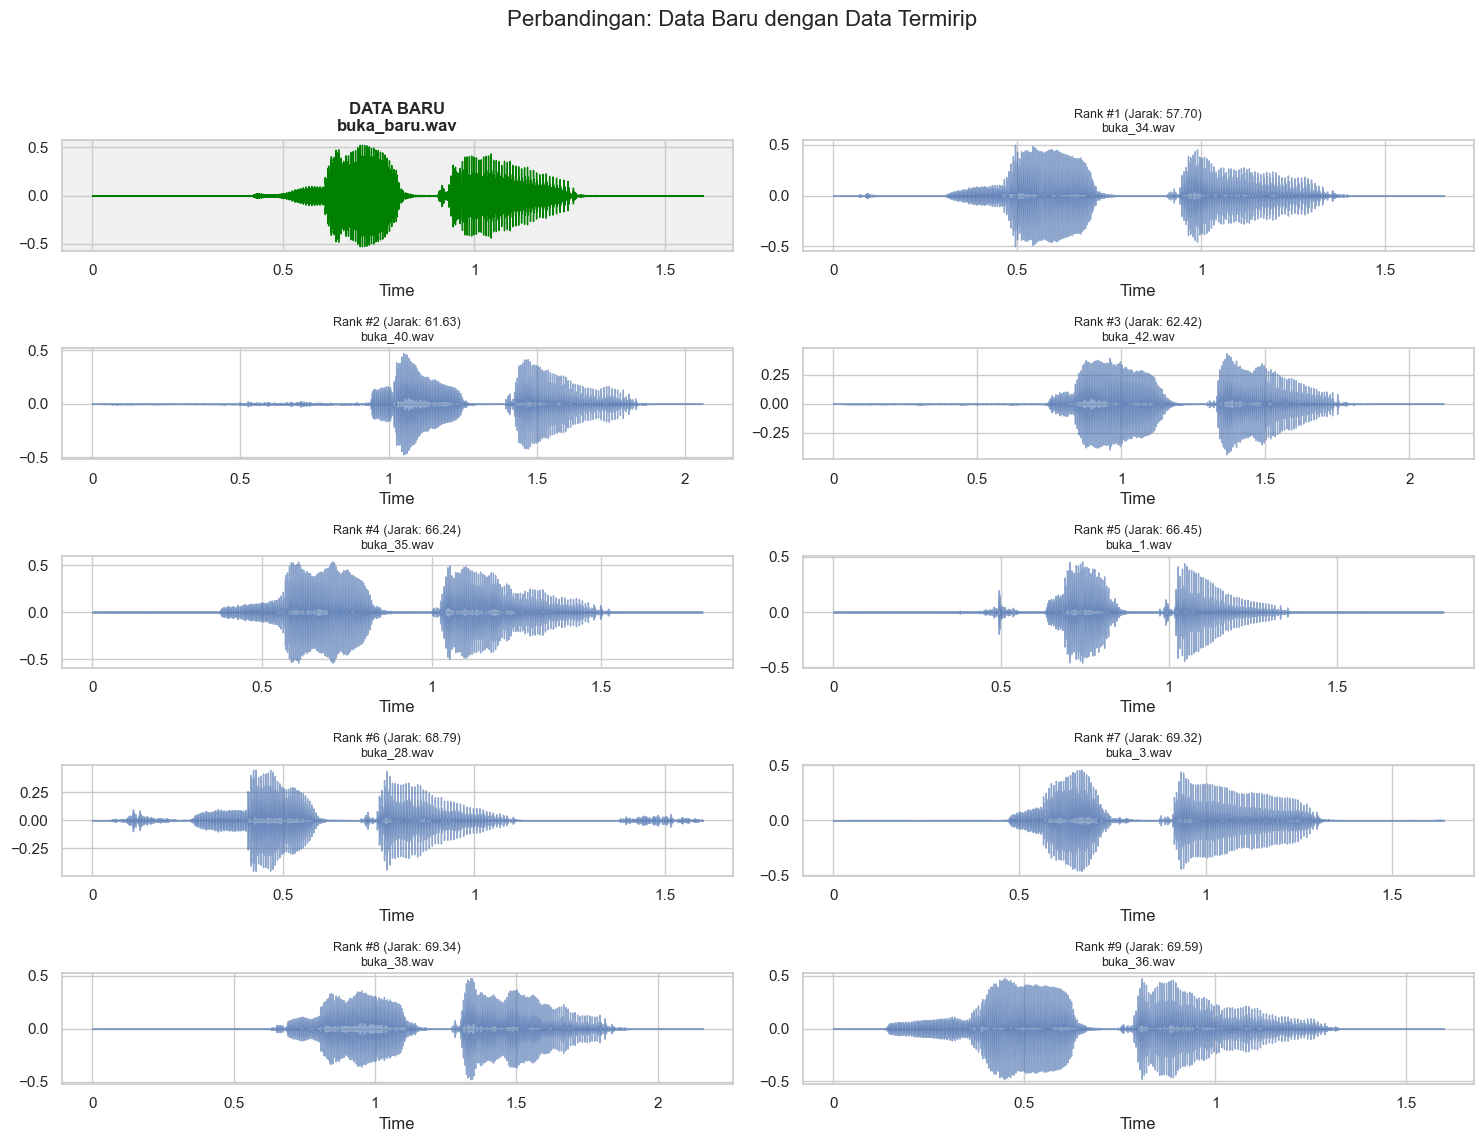

In [6]:
if not df_buka.empty:
    # Load Audio Baru
    y_new, sr_new = librosa.load(FILE_BARU, sr=TARGET_SR)
    
    # Siapkan Plot
    fig, axes = plt.subplots(5, 2, figsize=(15, 12))
    fig.suptitle('Perbandingan: Data Baru dengan Data Termirip', fontsize=16)
    axes = axes.flatten()
    
    # Plot Data Baru
    librosa.display.waveshow(y_new, sr=sr_new, ax=axes[0], color='green')
    axes[0].set_title(f"DATA BARU\n{os.path.basename(FILE_BARU)}", fontweight='bold')
    axes[0].set_facecolor('#f0f0f0') # Highlight background
    
    # Plot 9 Data Terbaik
    top_9_paths = df_buka_sorted['path_full'].iloc[:9].values
    top_9_dists = df_buka_sorted['jarak'].iloc[:9].values
    
    for i in range(9):
        ax_idx = i + 1
        ref_path = top_9_paths[i]
        dist = top_9_dists[i]
        
        y_ref, sr_ref = librosa.load(ref_path, sr=TARGET_SR)
        librosa.display.waveshow(y_ref, sr=sr_ref, ax=axes[ax_idx], alpha=0.6)
        axes[ax_idx].set_title(f"Rank #{i+1} (Jarak: {dist:.2f})\n{os.path.basename(ref_path)}", fontsize=9)
        axes[ax_idx].set_ylabel("")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### Ranking 100 Data Terbaik (BUKA)

In [7]:
if not df_buka.empty:
    print("DAFTAR LENGKAP 100 PERINGKAT (BUKA):")
    # Menampilkan 100 data
    with pd.option_context('display.max_rows', 100):
        display(df_buka_sorted[['file', 'jarak']].head(100))
    
    # Menampilkan dara terbaik Buka
    best_buka_score = df_buka_sorted.iloc[0]['jarak']
    print(f"\nData Terbaik BUKA: {best_buka_score:.4f}")

DAFTAR LENGKAP 100 PERINGKAT (BUKA):


,file,jarak
1,buka_34.wav,57.697561
2,buka_40.wav,61.626497
3,buka_42.wav,62.423257
4,buka_35.wav,66.244141
5,buka_1.wav,66.451202
6,buka_28.wav,68.786437
7,buka_3.wav,69.323130
8,buka_38.wav,69.335570
9,buka_36.wav,69.593213
10,buka_10.wav,70.976407



Data Terbaik BUKA: 57.6976


## Suara TUTUP  

### Load Data "TUTUP" & Visualisasi Waveform

Total file referensi 'TUTUP' dimuat: 100


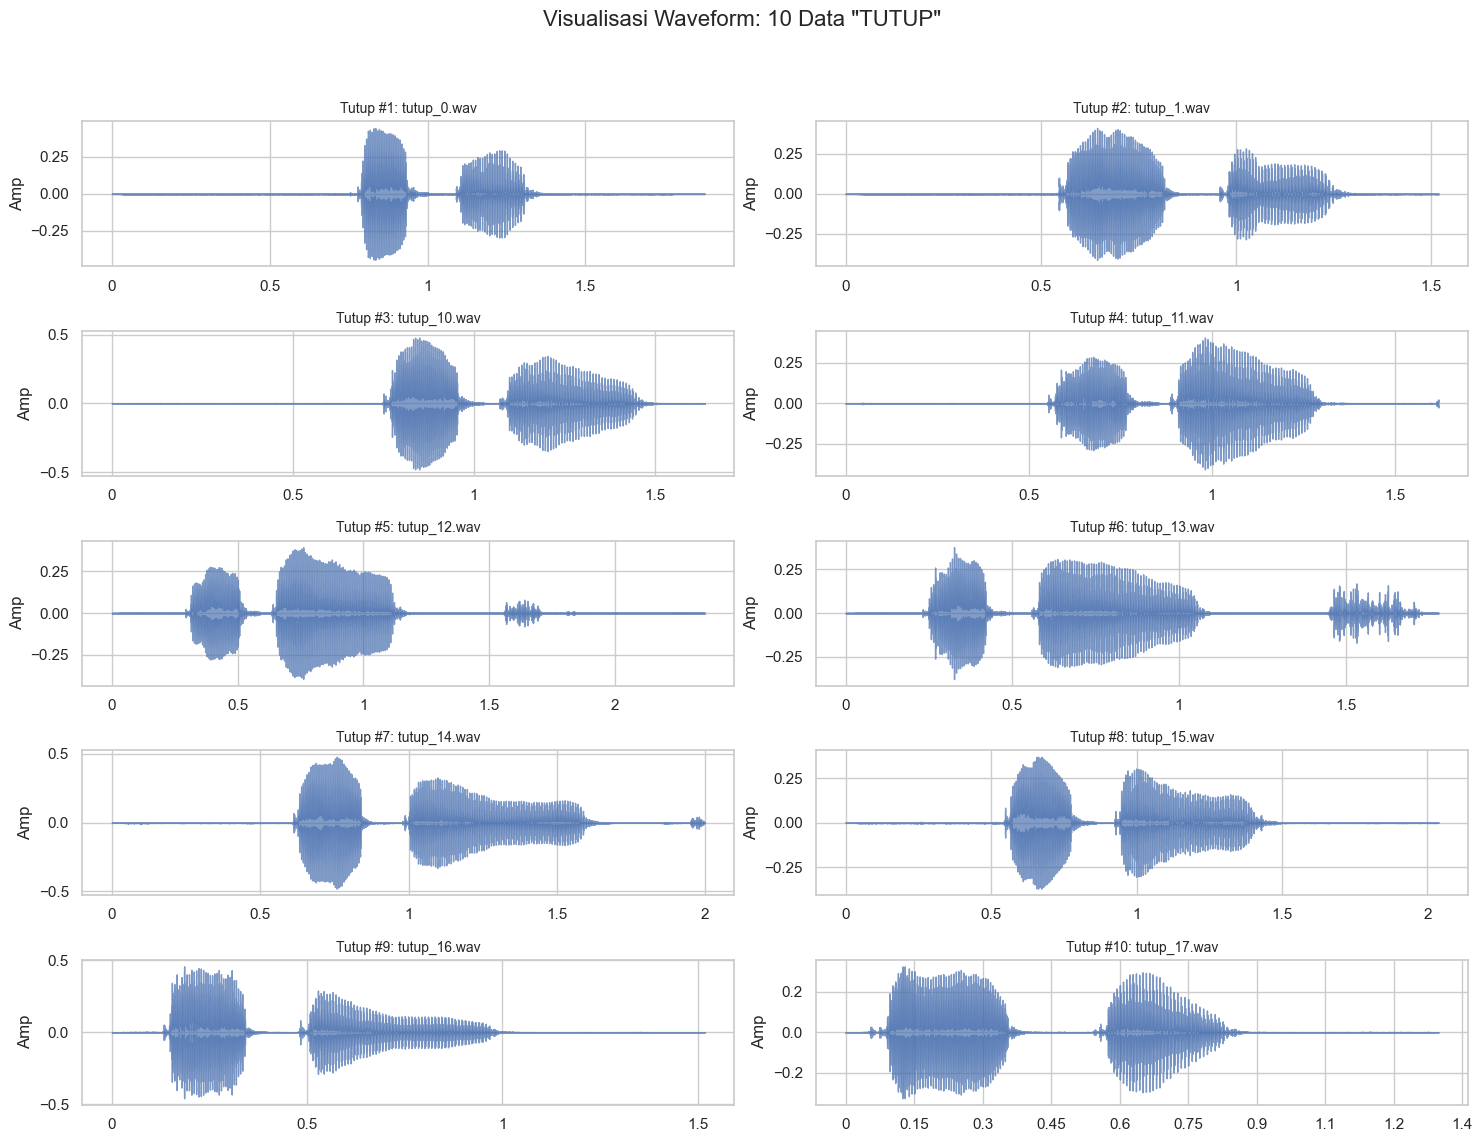

In [8]:
DATASET_PATH = "dataset/" 
TARGET_SR = 22050

# Load file TUTUP
files_tutup = glob.glob(os.path.join(DATASET_PATH, "**", "tutup", "*.wav"), recursive=True)
print(f"Total file referensi 'TUTUP' dimuat: {len(files_tutup)}")

# Visualisasi 10 Data Pertama
fig, axes = plt.subplots(5, 2, figsize=(15, 12))
fig.suptitle('Visualisasi Waveform: 10 Data "TUTUP"', fontsize=16)
axes = axes.flatten()

for i in range(10):
    if i < len(files_tutup):
        y, sr = librosa.load(files_tutup[i], sr=TARGET_SR)
        librosa.display.waveshow(y, sr=sr, ax=axes[i], alpha=0.7)
        axes[i].set_title(f"Tutup #{i+1}: {os.path.basename(files_tutup[i])}", fontsize=10)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("Amp")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Hitung Jarak (DTW) Data "TUTUP"

In [9]:
FILE_BARU_TUTUP = os.path.join("uji", "tutup", "tutup_baru.wav")

print(f"Menganalisis Input: {FILE_BARU_TUTUP}")

# Ekstrak Fitur Input
input_seq_tutup = extract_mfcc_dtw(FILE_BARU_TUTUP)
results_tutup = []

if input_seq_tutup is not None:
    print("Menghitung jarak terhadap 100 data 'TUTUP'")
    
    for ref_file in tqdm(files_tutup):
        ref_seq = extract_mfcc_dtw(ref_file)
        if ref_seq is not None:
            dist, path = fastdtw(input_seq_tutup, ref_seq, dist=euclidean)
            results_tutup.append({
                'file': os.path.basename(ref_file),
                'path_full': ref_file,
                'jarak': dist / len(path) # Normalisasi
            })
            
    df_tutup = pd.DataFrame(results_tutup)
    print("Perhitungan Selesai.")
else:
    print("Gagal memproses file input baru.")

Menganalisis Input: uji\tutup\tutup_baru.wav
Menghitung jarak terhadap 100 data 'TUTUP'


  0%|          | 0/100 [00:00<?, ?it/s]

Perhitungan Selesai.


### Statistik Hasil Jarak (TUTUP)

STATISTIK JARAK (TUTUP)
Jarak Terdekat (Min) : 40.7186
Jarak Terjauh (Max)  : 207.5256
Rata-rata Jarak      : 88.5454
Standar Deviasi      : 29.3410


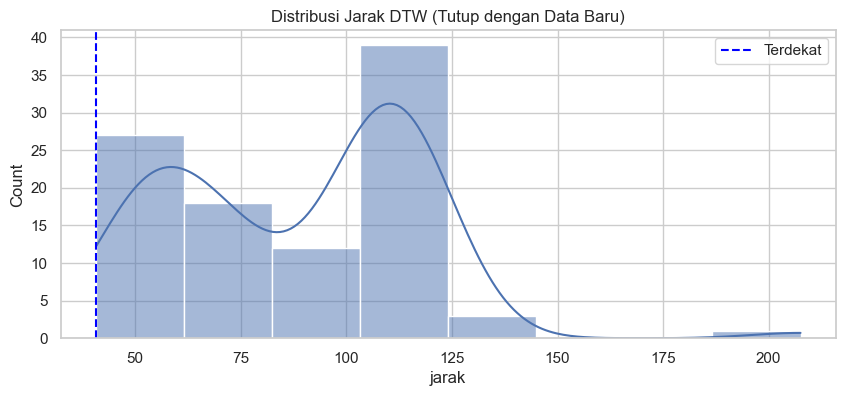

In [10]:
if not df_tutup.empty:
    print("STATISTIK JARAK (TUTUP)")
    stats_t = df_tutup['jarak'].describe()
    print(f"Jarak Terdekat (Min) : {stats_t['min']:.4f}")
    print(f"Jarak Terjauh (Max)  : {stats_t['max']:.4f}")
    print(f"Rata-rata Jarak      : {stats_t['mean']:.4f}")
    print(f"Standar Deviasi      : {stats_t['std']:.4f}")
    
    # Visualisasi Histogram
    plt.figure(figsize=(10, 4))
    sns.histplot(df_tutup['jarak'], kde=True)
    plt.axvline(stats_t['min'], color='blue', linestyle='--', label='Terdekat')
    plt.title("Distribusi Jarak DTW (Tutup dengan Data Baru)")
    plt.legend()
    plt.show()

### Ranking 20 Data Teratas (TUTUP)

TOP 20 PERINGKAT KEMIRIPAN (TUTUP):


,file,jarak
1,tutup_39.wav,40.718628
2,tutup_41.wav,41.643533
3,tutup_23.wav,44.717701
4,tutup_45.wav,45.191224
5,tutup_37.wav,48.022011
6,tutup_32.wav,49.037932
7,tutup_22.wav,50.010410
8,tutup_21.wav,50.233050
9,tutup_42.wav,50.278033
10,tutup_38.wav,50.623916


C:\Users\acer\AppData\Local\Temp\ipykernel_30568\1799456013.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='jarak', y='file', data=df_tutup_sorted.head(20), palette='magma')


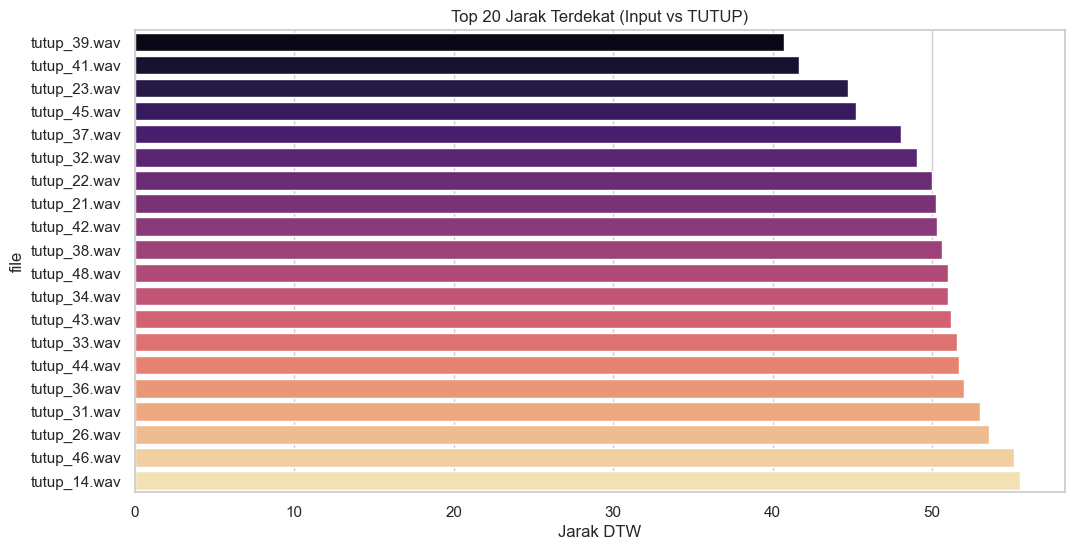

In [11]:
if not df_tutup.empty:
    # Ranking
    df_tutup_sorted = df_tutup.sort_values(by='jarak', ascending=True).reset_index(drop=True)
    df_tutup_sorted.index += 1
    
    print("TOP 20 PERINGKAT KEMIRIPAN (TUTUP):")
    display(df_tutup_sorted[['file', 'jarak']].head(20))
    
    # Visualisasi Bar Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='jarak', y='file', data=df_tutup_sorted.head(20), palette='magma')
    plt.title("Top 20 Jarak Terdekat (Input vs TUTUP)")
    plt.xlabel("Jarak DTW")
    plt.show()

### Visualisasi Perbandingan

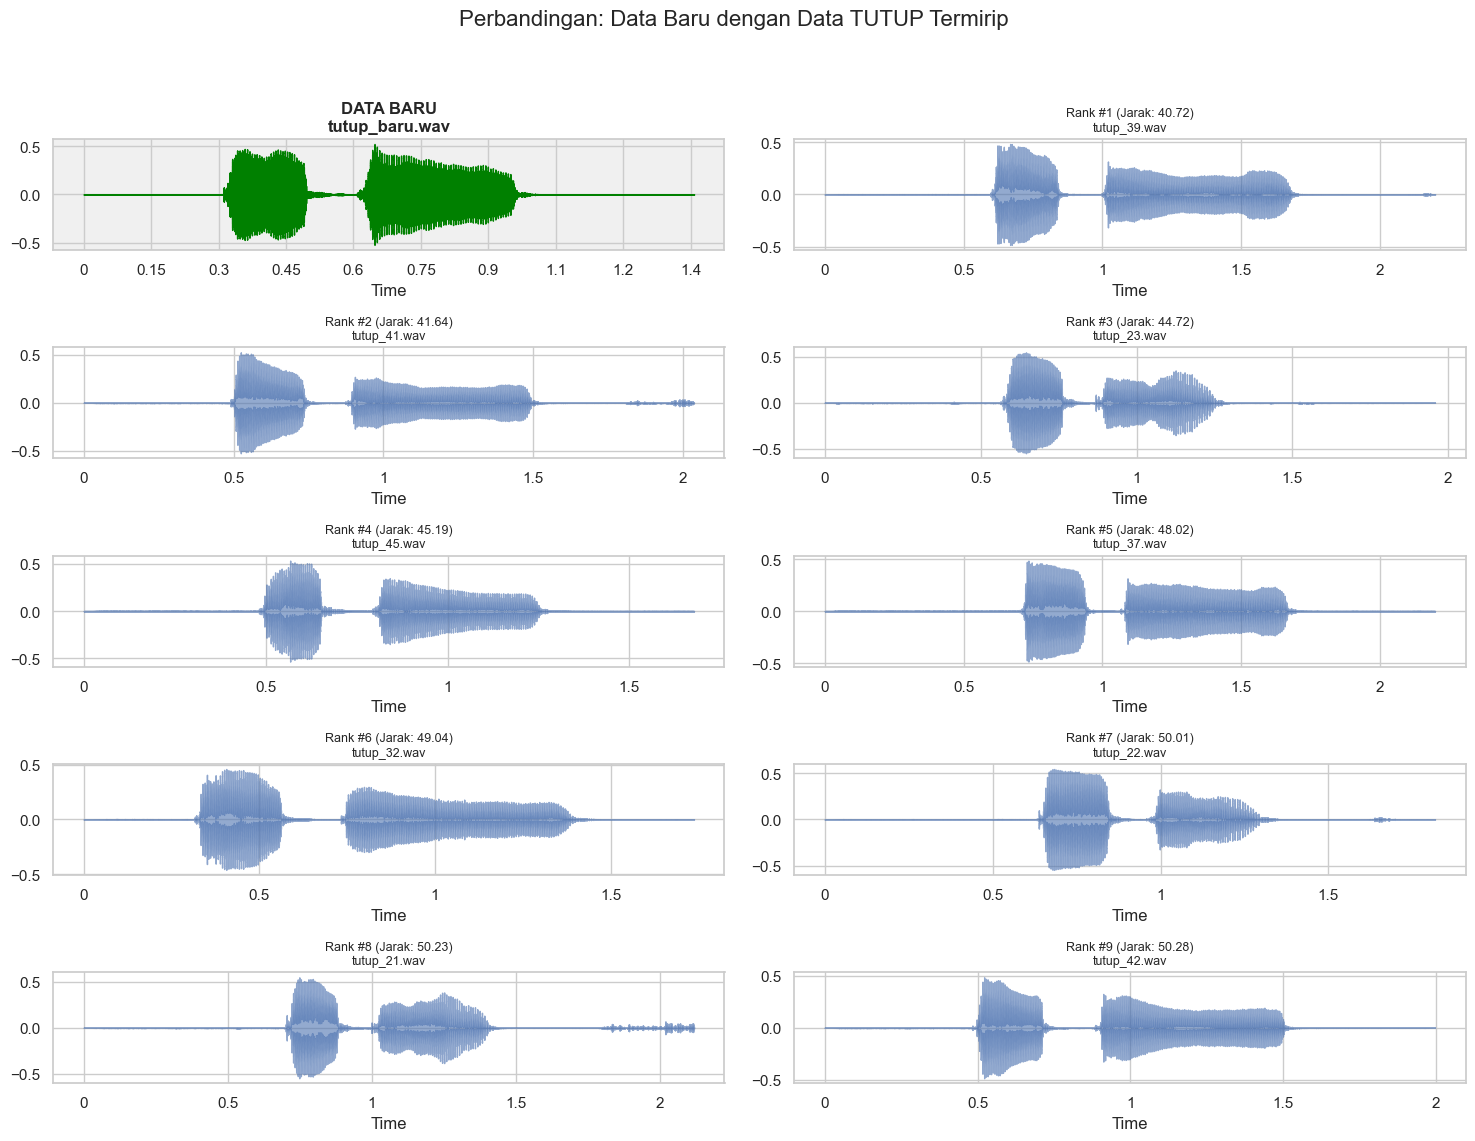

In [12]:
if not df_tutup.empty:
    # Load Audio Baru
    y_new_t, sr_new_t = librosa.load(FILE_BARU_TUTUP, sr=TARGET_SR)
    
    # Siapkan Plot
    fig, axes = plt.subplots(5, 2, figsize=(15, 12))
    fig.suptitle('Perbandingan: Data Baru dengan Data TUTUP Termirip', fontsize=16)
    axes = axes.flatten()
    
    # Plot Data Baru
    librosa.display.waveshow(y_new_t, sr=sr_new_t, ax=axes[0], color='green')
    axes[0].set_title(f"DATA BARU\n{os.path.basename(FILE_BARU_TUTUP)}", fontweight='bold')
    axes[0].set_facecolor('#f0f0f0')
    
    # Plot 9 Data Terbaik
    top_9_paths = df_tutup_sorted['path_full'].iloc[:9].values
    top_9_dists = df_tutup_sorted['jarak'].iloc[:9].values
    
    for i in range(9):
        ax_idx = i + 1
        ref_path = top_9_paths[i]
        dist = top_9_dists[i]
        
        y_ref, sr_ref = librosa.load(ref_path, sr=TARGET_SR)
        librosa.display.waveshow(y_ref, sr=sr_ref, ax=axes[ax_idx], alpha=0.6)
        axes[ax_idx].set_title(f"Rank #{i+1} (Jarak: {dist:.2f})\n{os.path.basename(ref_path)}", fontsize=9)
        axes[ax_idx].set_ylabel("")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### Ranking 100 Data Terbaik (TUTUP)

In [13]:
if not df_tutup.empty:
    print("DAFTAR LENGKAP 100 PERINGKAT (TUTUP):")
    with pd.option_context('display.max_rows', 100):
        display(df_tutup_sorted[['file', 'jarak']].head(100))
    
    best_tutup_score = df_tutup_sorted.iloc[0]['jarak']
    print(f"\nData Terbaik TUTUP: {best_tutup_score:.4f}")

DAFTAR LENGKAP 100 PERINGKAT (TUTUP):


,file,jarak
1,tutup_39.wav,40.718628
2,tutup_41.wav,41.643533
3,tutup_23.wav,44.717701
4,tutup_45.wav,45.191224
5,tutup_37.wav,48.022011
6,tutup_32.wav,49.037932
7,tutup_22.wav,50.010410
8,tutup_21.wav,50.233050
9,tutup_42.wav,50.278033
10,tutup_38.wav,50.623916



Data Terbaik TUTUP: 40.7186


## Perbandingan antara BUKA dan TUTUP


KEPUTUSAN AKHIR: BUKA VS TUTUP
Jarak Terdekat ke 'TUTUP' : 40.7186
Jarak Terdekat ke 'BUKA'  : 57.6976
----------------------------------------
HASIL PREDIKSI: TUTUP
(Lebih dekat 16.9789 poin dibanding Buka)


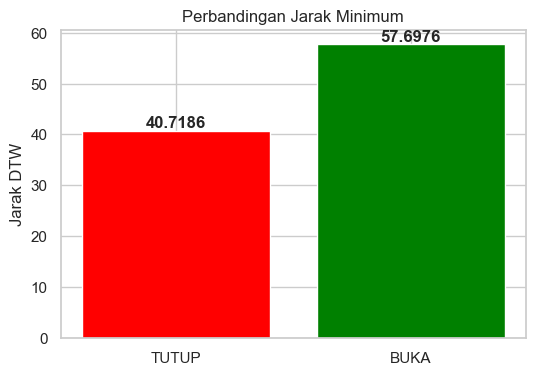

In [14]:
print("\n" + "="*40)
print("KEPUTUSAN AKHIR: BUKA VS TUTUP")
print("="*40)

print(f"Jarak Terdekat ke 'TUTUP' : {best_tutup_score:.4f}")
print(f"Jarak Terdekat ke 'BUKA'  : {best_buka_score:.4f}")
print("-" * 40)

# Logika Keputusan
if best_tutup_score < best_buka_score:
    selisih = best_buka_score - best_tutup_score
    print(f"HASIL PREDIKSI: TUTUP")
    print(f"(Lebih dekat {selisih:.4f} poin dibanding Buka)")
else:
    selisih = best_tutup_score - best_buka_score
    print(f"HASIL PREDIKSI: BUKA")
    print(f"(Lebih dekat {selisih:.4f} poin dibanding Tutup)")

# Visualisasi Bar
plt.figure(figsize=(6, 4))
bars = plt.bar(['TUTUP', 'BUKA'], [best_tutup_score, best_buka_score], color=['red', 'green'])
plt.title("Perbandingan Jarak Minimum")
plt.ylabel("Jarak DTW")
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom', fontweight='bold')
plt.show()